In [1]:
import math
import torch
import gpytorch
import pyro
import tqdm
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append("../")
from kernels import SpaceKernel
from torch.nn.functional import softplus
%matplotlib inline

In [2]:
torch.random.manual_seed(99)

## Build The True Kernel and Generate Data

In [3]:
kern = SpaceKernel()

In [4]:
r_bao = torch.tensor(100/0.7/1000) # Gpc
w_bao = torch.tensor(15/0.7/1000) # Gpc
print(r_bao)
print(w_bao)
raw_r_bao = torch.log(torch.exp(r_bao) - 1)
raw_w_bao = torch.log(torch.exp(w_bao) - 1)

tensor(0.1429)
tensor(0.0214)


In [5]:
print(raw_r_bao)
print(raw_w_bao)

tensor(-1.8736)
tensor(-3.8323)


In [6]:
kern.raw_gauss_mean.data = raw_r_bao
kern.raw_gauss_sig.data = raw_w_bao

In [7]:
tau = torch.linspace(0, 0.3)
xi = kern(tau, torch.zeros(1,1)).evaluate()

torch.Size([100, 1])
torch.Size([1, 1])




In [8]:
base_kern = SpaceKernel()
base_cov = base_kern(tau, torch.zeros(1,1)).evaluate()

torch.Size([100, 1])
torch.Size([1, 1])




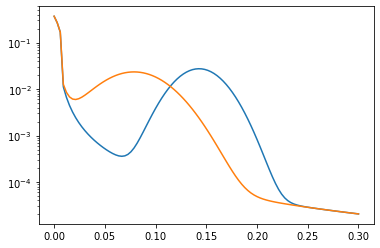

In [9]:
plt.plot(tau, xi.detach())
plt.plot(tau, base_cov.detach())
plt.yscale("log")

In [10]:
f = h5py.File("../data/comoving-positions.h5", 'r')
dset = f['pos']

In [11]:
obs = torch.FloatTensor(dset[()])

In [12]:
num_obs = 1746 ## just taken from sample dataset

## Setup Model with Correct Kernel

In [13]:
n = 10
dim = 3
inducing_pts = torch.zeros(pow(n, dim), dim)
for i in range(n):
    for j in range(n):
        for k in range(n):
            inducing_pts[i * n**2 + j * n + k][0] = float(i) / ((n-1) * 0.5) - 1.
            inducing_pts[i * n**2 + j * n + k][1] = float(j) / ((n-1) * 0.5) - 1.
            inducing_pts[i * n**2 + j * n + k][2] = float(k) / ((n-1) * 0.5) - 1.

inducing_row = torch.tensor([float(i) / ((n-1) * 0.5) - 1. for i in range(n)])

inducing_pts = inducing_pts.float()

In [14]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_arrivals, edge_len, inducing_pts, name_prefix="cox_gp_model"):
        self.name_prefix = name_prefix
        self.dim = inducing_pts.shape[-1]
        self.edge_len = edge_len
        self.mean_intensity = num_arrivals / (edge_len ** dim)
        num_inducing = inducing_pts.shape[0]
        
        # Define the variational distribution and strategy of the GP
        # We will initialize the inducing points to lie on a grid from 0 to T
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_pts, variational_distribution)

        # Define model
        super().__init__(variational_strategy=variational_strategy)

        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = SpaceKernel()

    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, arrival_times, quadrature_times):
        # Draw samples from q(f) at arrival_times
        # Also draw samples from q(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            pyro.sample(
                self.name_prefix + ".function_samples",
                self.pyro_guide(torch.cat([arrival_times, quadrature_times], 0))
            )

    def model(self, arrival_times, quadrature_times):
        pyro.module(self.name_prefix + ".gp", self)

        # Draw samples from p(f) at arrival times
        # Also draw samples from p(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            function_samples = pyro.sample(
                self.name_prefix + ".function_samples",
                self.pyro_model(torch.cat([arrival_times, quadrature_times], 0))
            )

        ####
        # Convert function samples into intensity samples, using the function above
        ####
        intensity_samples = function_samples.exp() * self.mean_intensity

        # Divide the intensity samples into arrival_intensity_samples and quadrature_intensity_samples
        arrival_intensity_samples, quadrature_intensity_samples = intensity_samples.split([
            arrival_times.size(0), quadrature_times.size(0)
        ], dim=-1)

        ####
        # Compute the log_likelihood, using the method described above
        ####
        arrival_log_intensities = arrival_intensity_samples.log().sum(dim=-1)
        
        ## avg intensity
        est_num_arrivals = quadrature_intensity_samples.mean(dim=-1).mul(self.edge_len ** self.dim)
        log_likelihood = arrival_log_intensities - est_num_arrivals
        pyro.factor(self.name_prefix + ".log_likelihood", log_likelihood)

In [15]:
model = GPModel(obs.shape[0], edge_len = 2., inducing_pts=inducing_pts)

In [16]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(7)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    inducing_pts = inducing_pts.cuda()
    model = model.cuda()

In [17]:
test = model(inducing_pts).sample(sample_shape=torch.Size((1,))).squeeze()

torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([1000, 3])




In [18]:
tt = test.view(n,n,n)

In [19]:
from scipy.interpolate import RegularGridInterpolator

In [20]:
interp = RegularGridInterpolator((inducing_row, inducing_row, inducing_row),
                                tt.cpu().numpy())

### Generate Random Points

In [21]:
import seaborn as sns
import pandas as pd

In [22]:
Ndraw = 8000
rs = np.cbrt(0.74**3*torch.rand(Ndraw).cpu().numpy())

In [23]:
cos_thetas = np.random.uniform(low=-1, high=1, size=Ndraw)
sin_thetas = np.sqrt(1-cos_thetas*cos_thetas)
phis = np.random.uniform(low=0, high=2*math.pi, size=Ndraw)

pts = np.column_stack((rs*np.cos(phis)*sin_thetas,
                rs*np.sin(phis)*sin_thetas,
                rs*cos_thetas))

rs = np.sqrt(np.sum(np.square(pts[:,np.newaxis,:] - pts[np.newaxis,:,:]), axis=2))

In [24]:
# sns.pairplot(pd.DataFrame(pts))

### Compute Covariance and Rejection Sample

#### First set the hypers of the kernel to be correct

In [25]:
model.covar_module.raw_gauss_mean.data = torch.log(torch.exp(r_bao) - 1)
model.covar_module.raw_gauss_sig.data = torch.log(torch.exp(w_bao) - 1)

In [26]:
sample_intensity = model(torch.tensor(pts).float()).sample(sample_shape=torch.Size((1,))).squeeze()
sample_intensity = sample_intensity.div(sample_intensity.max())
pts = pts[torch.rand(Ndraw).cpu() < sample_intensity.cpu(), :]
print('Drew {:d}'.format(pts.shape[0]))

torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([8000, 3])


torch.Size([8000, 3])
torch.Size([8000, 3])


Drew 966


In [27]:
pts = pd.DataFrame(data=pts, columns=['x', 'y', 'z'])

In [28]:
# sns.pairplot(pts, markers='.')

#### Now that we have points just override the kernel

In [29]:
model.covar_module = SpaceKernel()

In [30]:
print(model.covar_module.raw_gauss_mean)
print(model.covar_module.raw_gauss_sig.shape)

Parameter containing:
tensor([[-2.5000]], requires_grad=True)
torch.Size([1, 1])


#### Override kernel to see what happens if mean is too high

In [31]:
# model.covar_module.raw_gauss_mean.data = (raw_r_bao + 1.).cuda()
model.covar_module.raw_gauss_mean

Parameter containing:
tensor([[-2.5000]], requires_grad=True)

In [32]:
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 40
num_particles = 1 if smoke_test else 32

train_pts = torch.tensor(pts.values).float()
inducing_pts = inducing_pts.float()

def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr": lr})
    loss = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=False, retain_graph=True)
#     loss = pyro.infer.Trace_ELBO()
    infer = pyro.infer.SVI(model.model, model.guide, optimizer, loss=loss)

    model.train()
    loader = tqdm.tqdm_notebook(range(num_iter))
    for i in loader:
        loss = infer.step(train_pts, inducing_pts)
        loader.set_postfix(loss=loss)
        
        print(softplus(model.covar_module.raw_gauss_mean))
        print(softplus(model.covar_module.raw_gauss_sig))

train()

torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1966, 3])
torch.Size([1966, 3])


torch.Size([1000, 3])
torch.Size([1000, 3])


torch.Size([1000, 3])
torch.Size([

KeyboardInterrupt: 

In [ ]:
function_dist = model(inducing_pts)
intensity_samples = function_dist(torch.Size([1000])).exp() * model.mean_intensity

In [ ]:
intensity_samples.shape

In [ ]:
tau = torch.linspace(0, 0.3)
cov = model.covar_module(tau, torch.zeros(1,1)).evaluate()

In [ ]:
fpath = "./saved_gwbao_model.pt"
torch.save(model.state_dict(), fpath)

In [ ]:
plt.plot(cov.detach().log().cpu())

In [ ]:
torch.nn.functional.softplus(model.covar_module.raw_gauss_mean)

In [ ]:
torch.nn.functional.softplus(model.covar_module.raw_gauss_sig)

### Using Saved Model Do Some Plotting

In [ ]:
model.load_state_dict(torch.load("./saved_gwbao_model.pt"))

In [ ]:
base_kern = SpaceKernel()
# base_kern.raw_gauss_mean.data = raw_r_bao + 1.
true_kern = SpaceKernel()
true_kern.raw_gauss_mean.data = raw_r_bao
true_kern.raw_gauss_sig.data = raw_w_bao

In [ ]:
learn_cov = model.covar_module(tau, torch.zeros(1,1)).evaluate()
base_cov = base_kern(tau, torch.zeros(1,1)).evaluate()
true_cov = true_kern(tau, torch.zeros(1,1)).evaluate()

In [ ]:
plt.plot(tau.cpu(), learn_cov.detach().cpu(), label="learned")
plt.plot(tau.cpu(), base_cov.detach().cpu(), label="initial")
plt.plot(tau.cpu(), true_cov.detach().cpu(), label="truth")
plt.yscale("log")
plt.legend()
plt.title("(Log) GP Covariance for Cox Process")
plt.xlabel(r"$\tau$")
plt.ylabel("Log Covariance")